# Data Analytics Project
## Prediction and analysis of marital status of people in USA over the years

Authors: Julia Nowak, Adam Złocki

### 1. Problem formulation


##### 1.1 Main problem
The goal of the project is to predict the number of married adults in U.S. society. The problem does not focus on specific races - general data applicable to all races has been used. However, the selected dataset allows for dividing the data by race and conducting separate analyses of marital status. The idea of the project is based on the current topic concerning the hypothetical decline in the number of marriages and the increase in the number of divorces in highly developed countries such as the USA. During the analysis, we want to demonstrate existing trends and predict the distribution of the values we are interested in for the future.

##### 1.2 Examples of use and reasons for analysis
The problem of predicting marital status and the number of marriages in society is extremely important from the government's perspective. This is an issue worth analyzing, especially for planning the U.S. government's family policy. The topic is also significant for all types of estimates related to natural population growth and social conditions. The analysis can provide the government with early indications of certain changes occurring in society, which should be considered when creating future plans. It can also be useful while creating campaigns focused on specific social groups or while analysing social structure of society.

##### 1.3 Data origin and content
The data we are using comes from the official U.S. government website (www.census.gov). It includes information on the number of people with a given marital status by year, the average age of first marriage, the number of households, and the overall average income per household member to present the general economic situation of the society.

Additionally, the data is available with a division by race, allowing for predictions for each race separately and subsequent comparative analysis, although we did not adopt this approach. The data we use is historical, spanning from the 20th century to 2023, with the latest update in November 2023, making it relatively recent. For the analysis, we used the years 1993-2023, excluding duplicates of some years (choosing the most recent data from each pair).

The data includes various tables from the Current Population Survey (CPS), conducted annually by the U.S. Census Bureau.

While creating the dataset, the following columns were included:
- Year - the year in which the data was collected,
- Married - number of people married in a given year (in thousands),
- Divorced - number of people divorced in a given year (in thousands),
- Single - number of people being single in a given year (in thousands),
- Income per member - average income per household member in a given year,
- Income - average total income in a given year,
- Mean age - the average age of entering into first marriage in a given year,
- Household - number of households in a given year,
- Total - total population (in thousands)

owever, only the columns Year, Married, Income per member, Mean age, and Household were used for the analysis.

##### 1.4 DAG diagram
The following DAG diagram represents the dependencies utilized in our project. For our predictions, we applied average household income per member and the number of households, allowing us to examine the impact of the overall economic situation of society on the number of marriages. Additionally, we also took into account the average age of first marriage, which is connected with the cultural changes in the society. As we think about it and if we check the data, we can assume that:
- every year the number of household increses, which may be associated with a growing population or increased demand for households - the increased number of housing units may encourage a rise in the number of marriages in the given year, as for many people, owning a home can be a marker of stability and independence,
- every year the income per member increses, which may be connected with economical changes and can affect number of marriages - the marriage is connected with huge expenses, so it can be a factor that influences the number of marriages in a given year,
- every year the mean age of the first marriage increses, which depends on cultural influence and world changes, so it can be a crucial if we want to analyse number of marriages in a given year (the influence of generations may result in increased number of marriages in specific year),
- every year the number of marriages increses.

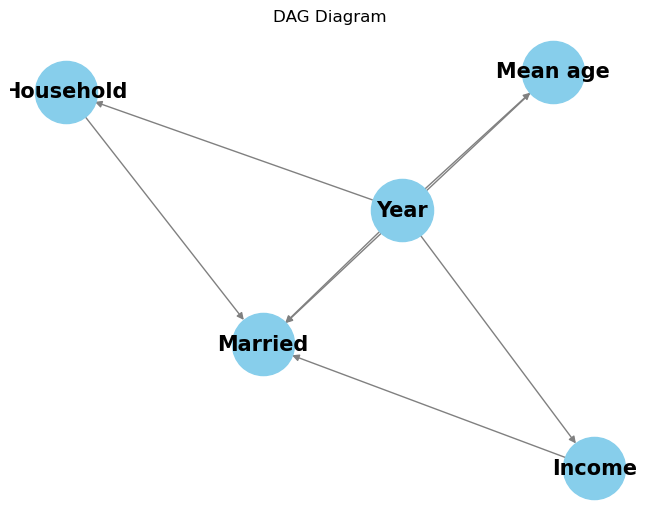

In [877]:
# WARNING
# Income per member is used as "income" for the diagram

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Mean age")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Household")
G.add_edge("Year", "Income")
G.add_edge("Year", "Mean age")
G.add_edge("Year", "Married")


G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("DAG Diagram")
plt.show()


##### 1.5 Confoundings

- COLLIDERS 

    The collider is an inverted fork that represents the node where two or more arrowheads meet. Here we can see that Household, Mean age, Income and Year creates collider from the point of view in the Married node. All of them have impact on Married results, which may be connected with issues finding the problematic node, if the results are not correct.

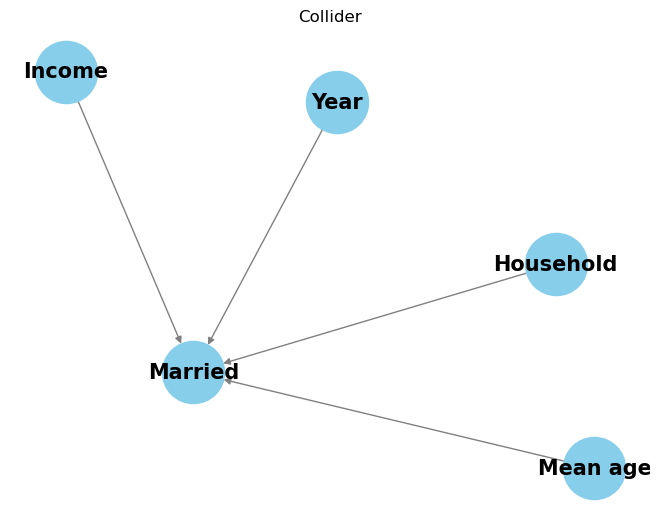

In [878]:
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Income")
G.add_node("Mean age")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Married")
G.add_edge("Income", "Married")
G.add_edge("Household", "Married")
G.add_edge("Mean age", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("Collider")
plt.show()

- FORKS

    The fork represents the situation where one node creates at least two paths. Here we can see that the node of Year creates fork with 3 different paths:\
    Year -> Mean age -> Married \
    Year -> Household -> Married \
    Year -> Income -> Married 

    It means that one node can influence different nodes, so it is connected with higher risk that this node may have stronger impact on the results. 

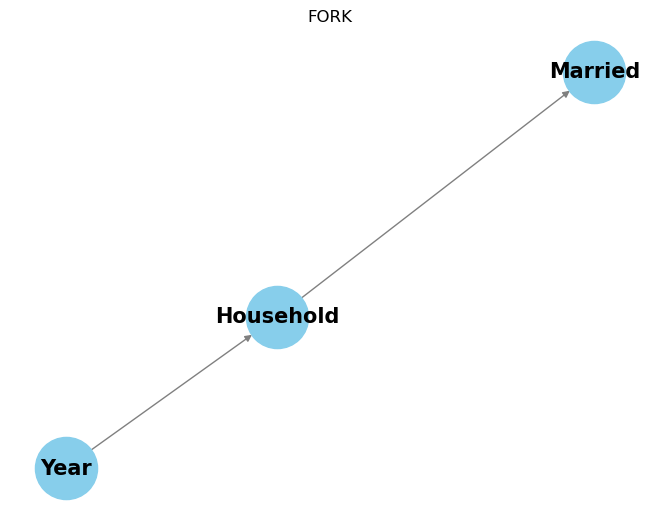

In [879]:
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Household")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Household")
G.add_edge("Household", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("FORK")
plt.show()


- PIPES

    The pipe represents flow or influence in the DAG diagram. This is the basic connection between each node and it shows thar one variable has an impct on the other. It helps find reason, why the results are incorrect, step by step. Here, the examples of pipes are:\
    Year -> Married \
    Year -> Household \
    Year -> Income \
    Year -> Mean age 

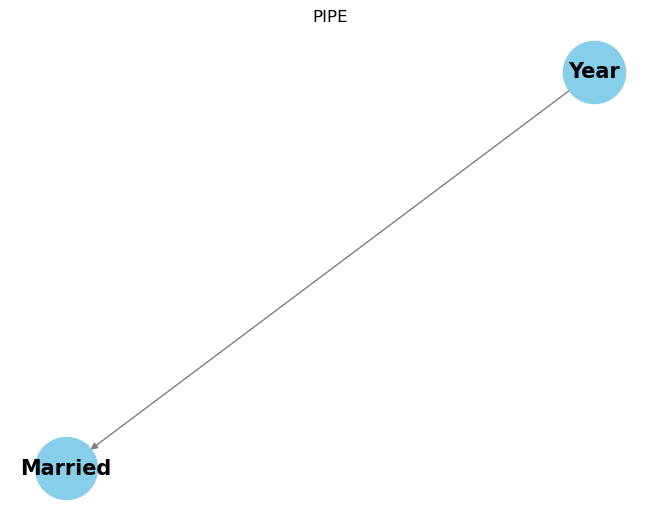

In [880]:
G = nx.DiGraph()

# Add nodes
G.add_node("Year")
G.add_node("Married")


# Add edges
G.add_edge("Year", "Married")

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='gray', font_size=15, font_weight='bold')

plt.title("PIPE")
plt.show()

The data can be represented differently based on the way of thinking. All our columns are higly correlated and it means that they all might have influence on each other.

### 2. Data Preprocessing

##### 2.1 Steps of preprocessing

The preprocessing in our case was quite complicated, since we are using data that was dispersed in a different tables. They describe the same survey, but data was merged from different Excel sheets into one table with all values that are interesting for us. We can call it a step 0 of the preprocessing. After creating the table, we proceeded to the main preprocessing part.

The preprocessing were divided into 3 steps:
- selection of years and races (selection of specific years - some data is left to use as a testing data),
- data notes (getting to know about important changes/events during the years that were taken into consideration)
- data cleaning (all actions taken to clean the data - changes in formatting, merging columns, deletions and calculations)

##### 2.2 Reasoning and actions taken

1. Selection of analyzed years and races:

- Years 1993-2022 were chosen for analysis (almost 30 years of data) - the data is pretty confident and there are not any gaps between years for this range of time,
- Years 2017-2022 were set aside for model evaluation, so we can know, if our models are not overfitted or if they give us correct results,
- The focus was on analysing overall data across all races combined - we could select specific races, but for our problem, there is no need to do that.

2. Data notes - it is important to acknowledge this information during analysing data:

- In years 2011 and 2021, the data included duplicate results due to presenting both original and updated values based on the latest decennial population census (updated values were selected, since they were more accurate to the population in the given years),
- In 2014, there was a change in income-related survey questions, resulting in differences in questions asked to respondents - the answers may vary, but there was not any huge changes in the income values after introducing new questions,
- Since 2019, same-sex marriages have also been included - it doesn't influence the survey results significantly.

3. Data cleaning:

- Year format was changed from "..2011" to a format without dots - it was crucial, since dots were giving wrong data format for this column and it was impossible to use.
- Year 2023 was excluded due to income data being from previous years - income is updated with delay, so it will be probably updated in 2024, so we couldn't use data from this year.
- Duplicated years were removed - only one of them (updated one) was left, since it better represents population at this time.
- Data was merged to omit gender considerations - we could analyse marriages based on gender, but as with race, it was not strictly connected to our problem.
- Total respondents were calculated (including data beyond the analyzed period) - it gave us better insight into data and may be use in normalization (as a different approach to a problem).
- Household data was selected from a separate table for improved results.
- Years were transformed into numbers and data types were standardized to make data useable in Python.


##### 2.3 Getting to know the data
Import necessary libraries

In [881]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import random

import warnings
import cmdstanpy
from cmdstanpy import CmdStanModel

import arviz as az
import scipy.stats as stats
# warnings.filterwarnings('ignore')

Reading data from a concatenated file

In [882]:
# Read from excel file
df_ac  = pd.read_excel("data.xlsx", sheet_name="Raw_data")

# Select only essential columns
df = df_ac[['Year', 'Married', 'Income per member', "Mean age", "Household"]]

Data splitting

In [883]:
# All data for testing purposes
df_all = df

# Selection of years - 5 years are left for checking results
df = df[:25]

# Quick look at the table
df.head()

,Year,Married,Income per member,Mean age,Household
0,1993,114601,15500,25.50,96391
1,1994,115253,16300,25.60,97107
2,1995,116554,16940,25.70,98990
3,1996,116561,17850,25.95,99627
4,1997,116752,18940,25.90,101018


Preliminary data analysis

In [884]:
# Data for models
df.describe()

,Year,Married,Income per member,Mean age,Household
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,2005.000000,125517.720000,24412.000000,26.690000,112143.720000
std,7.359801,6685.028917,5173.445821,0.941962,9520.963469
min,1993.000000,114601.000000,15500.000000,25.500000,96391.000000
25%,1999.000000,119040.000000,21060.000000,25.950000,103874.000000
50%,2005.000000,127142.000000,24670.000000,26.350000,113343.000000
75%,2011.000000,130767.000000,27330.000000,27.400000,119927.000000
max,2017.000000,135749.000000,34640.000000,28.450000,126224.000000


In [885]:
# Data for checking purposes
df_all[25:].describe()

,Year,Married,Income per member,Mean age,Household
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2020.000000,136807.400000,39212.000000,29.120000,129012.400000
std,1.581139,922.352319,2530.784463,0.270647,1358.823866
min,2018.000000,135704.000000,35700.000000,28.800000,127586.000000
25%,2019.000000,136297.000000,38410.000000,28.900000,128451.000000
50%,2020.000000,136506.000000,38760.000000,29.150000,128579.000000
75%,2021.000000,137758.000000,40860.000000,29.300000,129244.000000
max,2022.000000,137772.000000,42330.000000,29.450000,131202.000000


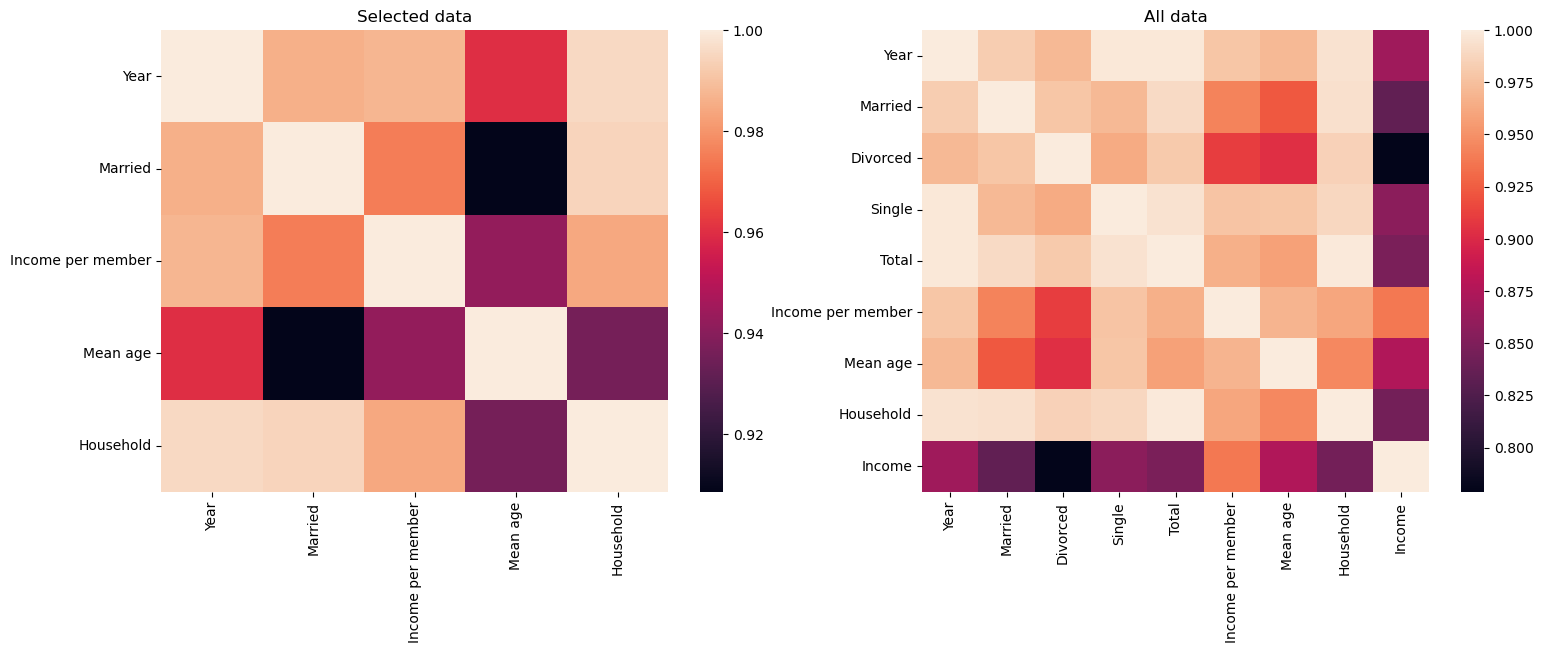

In [886]:
# Correlations

fig, ax = plt.subplots(1,2)

fig.set_size_inches(18, 6)

ax[0].set_title('Selected data')
sns.heatmap(df.corr(method="pearson"), ax=ax[0])

ax[1].set_title('All data')
sns.heatmap(df_ac.corr(method="pearson"), ax=ax[1])

plt.show()


Notice 

The data we selected are strongly correlated with each other (over 90% correlation). High correlation typically means values in one column can be predicted from another, suggesting redundancy or collinearity. It is recommended to avoid having correlated features in your dataset. Indeed, a group of highly correlated features will not bring additional information (or just very few), but will increase the complexity of the algorithm, thus increasing the risk of errors.
Using highly correlated predictors in techniques like linear regression can result in highly unstable models, numerical errors, and very poor prediction performance.

However, since we are interested only in prediction and we don't want to make the assumptions about the relations within the data, we can use it to build our model. As a different approach we could use normalization, but for now we decided to try the approach with initial data.

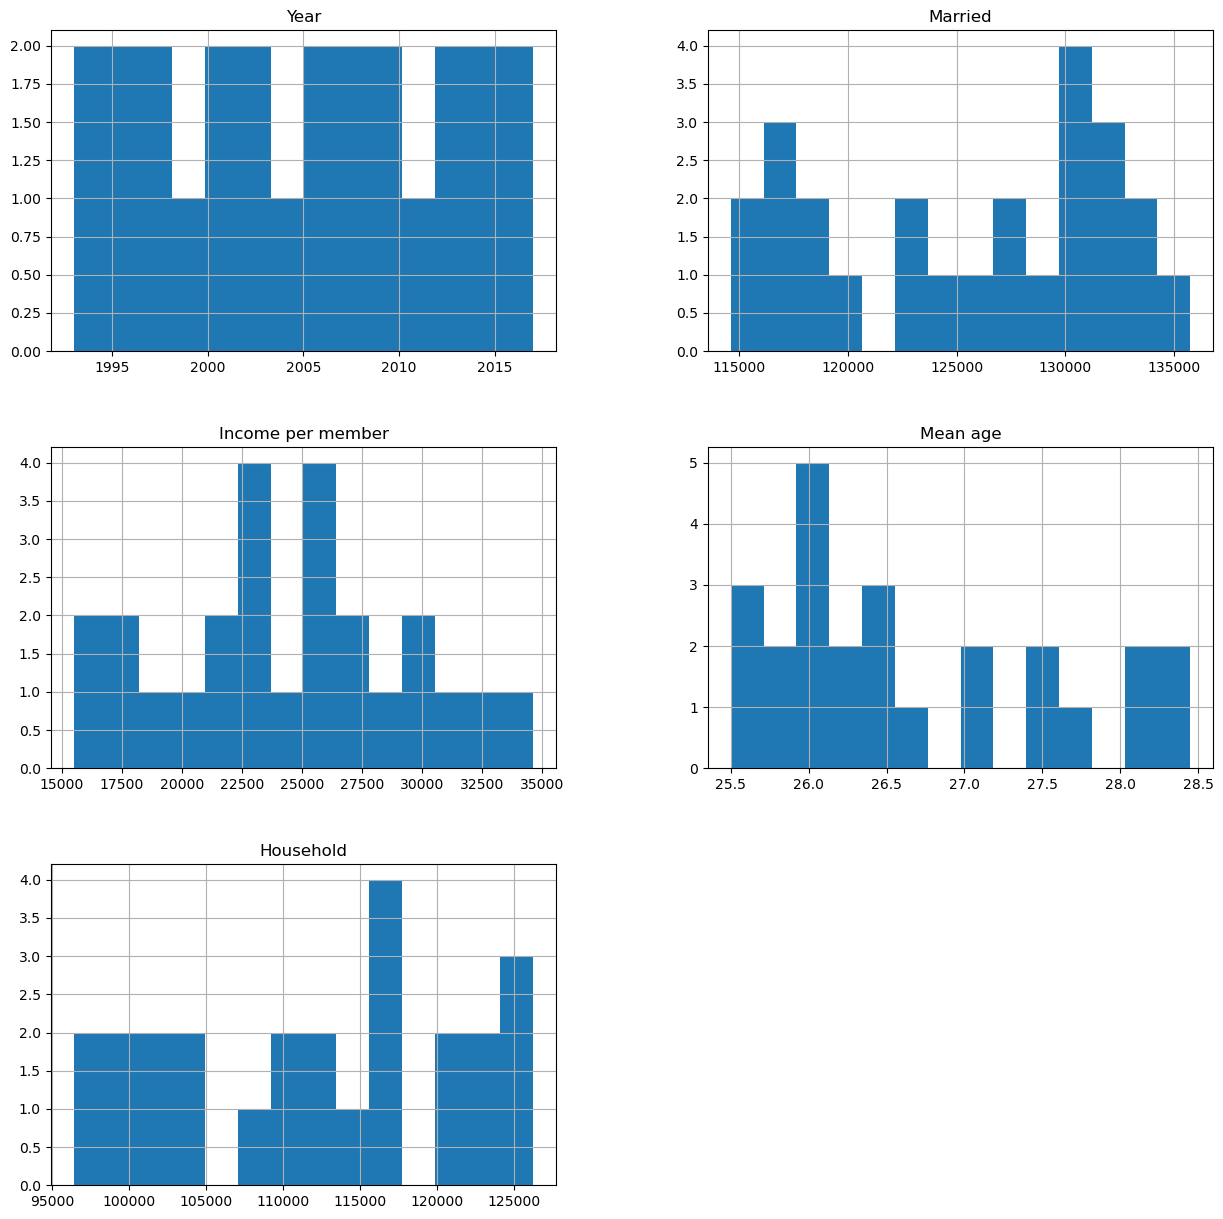

In [887]:
# Data overview
df.hist(figsize=(15,15), bins=14)
plt.show()

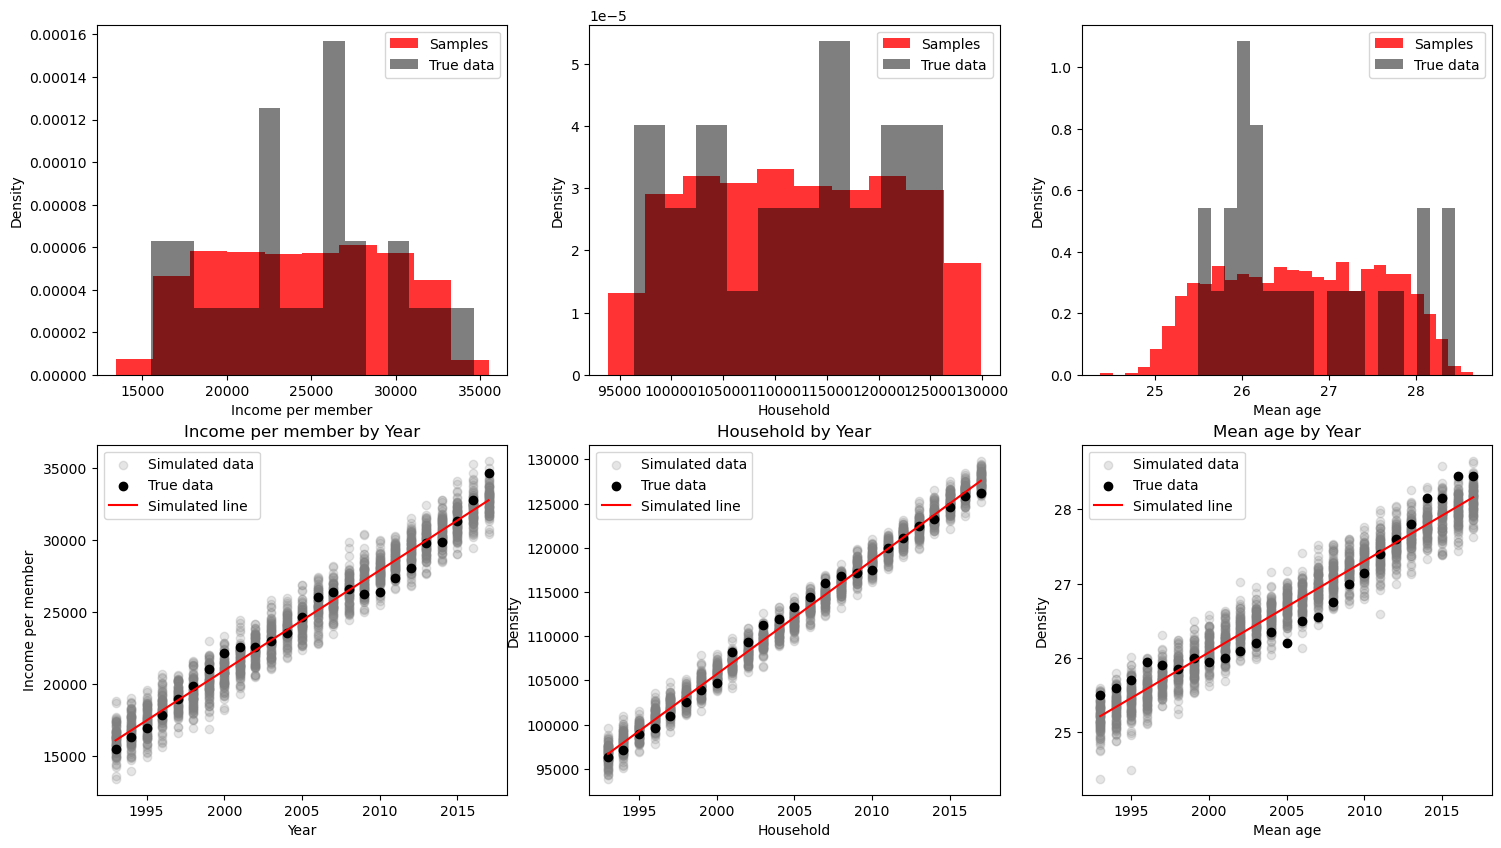

In [888]:
# Predictors - basic simulation

plt.figure(figsize=(18,10))
plt.subplot(2,3,1)

A = np.vstack([df['Year'], np.ones(len(df['Year']))]).T
a, b = np.linalg.lstsq(A, df['Income per member'], rcond=None)[0]

sim = random.normal(a*df['Year'] + b, 1000, (100, 25)) # mu, sigma, samples
# plt.plot(df['Income per member'], stats.norm.pdf(df['Income per member'], 25000, 4000), c='k')
plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Income per member'], color='black',bins=15, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Income per member')
plt.legend()

plt.subplot(2,3,4)
f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Income per member'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')
plt.title('Income per member by Year')
plt.ylabel('Income per member')
plt.xlabel('Year')
plt.legend()

plt.subplot(2,3,2)
a, b = np.linalg.lstsq(A, df['Household'], rcond=None)[0]

sim = random.normal(a*df['Year'] + b, 1000, (100, 25)) # a - from, b - to, samples
# 1/(a-b) - height
# plt.plot(df['Household'], [1/(126000-96000)]*len(df['Household']), linewidth=2, color='k')
plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, label="Samples")
plt.hist(df['Household'], color='black',bins=10, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()


plt.subplot(2,3,5)
f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Household'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')

plt.title('Household by Year')
plt.ylabel('Density')
plt.xlabel('Household')
plt.legend()

plt.subplot(2,3,3)
a, b = np.linalg.lstsq(A, df['Mean age'], rcond=None)[0]
sim = random.normal(a*df['Year'] + b, 0.2, (100, 25))

plt.hist(sim.flatten().tolist(), color='red', alpha = 0.8, density=True, bins=30, label="Samples")
plt.hist(df['Mean age'], color='black', bins=20, alpha = 0.5, density=True, label="True data")
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()

plt.subplot(2,3,6)

f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='gray', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='gray', alpha=0.2)
    f1 = True
plt.scatter(df['Year'], df['Mean age'], label="True data", color='black')
plt.plot(df['Year'], a*df['Year']+ b, label="Simulated line", color='r')
plt.title('Mean age by Year')
plt.ylabel('Density')
plt.xlabel('Mean age')
plt.legend()

plt.show()

As it can be seen, our predictors can all be represented in approximation as linear functions. The representation is not perfect, but it gives us pretty good results, especially if we consider using normal distribution with linear function. These plots give us good insight into how DAG diagram looks and how data may behave. However, they don't give us the information about number of married people, which is the main part of our problem. The Married data behaviour will be analyzed later, but since it will depend on these 3 predictors (or one), getting to know them better may be really helpful in the future.  

### 3. Models

##### 3.1 Two models - specification and description
We have created two models: 
- the first model predicts the number of individuals after marriage based on data about average household income per member of the household, 
- the second model additionally utilizes the number of households, average household income per member of the household and the average age of entering first marriage.

We incorporated additional information with the hope that expanding the context would improve the results and make them more reflective of reality.

Model I:

- Parameters:  $\alpha$, $\beta$, $\sigma$
- Data: Average household income per member
- Linear equation: f(income) = $\alpha$*income + $\beta$
- Sampling: y(income) = normal(f(income), $\sigma$)

Model II:

- Parameters: $\alpha_1$, $\alpha_2$, $\alpha_3$, $\beta$, $\sigma$
- Data: Average household income per member, number of households, average age of first marriage
- Linear equation: f(income, household, age) = $\alpha_1$*income + $\alpha_2$*household + $\alpha_3$*age + $\beta$
- Sampling: y(income) = normal(f(income, household, age), $\sigma$)




##### 3.2 Differences

The main differences in our two models is the number of parameters and the function that they use. Our first model is rather simple and it represents approach of linear regression. The second one, uses multiple linear regression approach, which is more complex since it uses more parameters and depends on more predictors. Moreover, adding additional predictors to the model makes sense. 

In our first model, we use income to predict number of married people, which is understandable (and was explained in 1.4). Adding more predictions gives us better insight into the data and let us know more about factors that impact the number of married people. Additional predictors allow us to create more complex data stories and assumpions about the data.

Despite highly correlated features, adding additional parameters also makes sense as it complicates the equation but does not significantly impact the prediction. The impact is smaller, but the difference is noticeable. 

##### 3.3 Models creation

In [889]:
# Creating models

N = 25
R = 100

model_1_prior = CmdStanModel(stan_file='prior.stan')
model_1_posterior = CmdStanModel(stan_file='posterior.stan')
model_2_prior = CmdStanModel(stan_file='tri_prior.stan')
model_2_posterior = CmdStanModel(stan_file='tri_posterior.stan')

### 4. Priors

##### 4.1 Selection of priors for parameters

In the problem we are considering, determining priors for the parameters was based on several stages. We started by creating graphs and analyzing the data. Then, looking at how the data is distributed, we decided to choose functions that represent our problem for both models.

For the first model, we decided to use a linear function that depends on income per member. For the second model, we used multiple linear regression that depends on income per member, the number of households and mean age. In both cases, we used normal distribution for sampling and for the distribution of parameters.

Why we use normal distribution? Because it has a lot of advantages, especially in our case. The normal distribution is used as a common method while performing linear regression with stan. It is also very pretty easy to understand and is common in nature. After testing distributed parameters for "Married" and predictors, they gave us good results, so we decided to use normal distribution. 
The results are not perfect and parameters can be chosen better, but it would need performing additional parameter testing or changing distribution type.

After establishing the equations, it was necessary to select the appropriate ranges for the parameters. To determine the best fit, the "linalg.lstsq" function was used, which helped in choosing the parameters that best matched the course of our data. With these values in hand, the only remaining task was to determine the range within which these parameters could vary to yield meaningful results. This information was obtained by determining the lower and upper bounds of the parameter distribution and the results of the equations.


We have chosen following priors for our models:
- For model I:
    * $\alpha$ ∼ normal(1.26, 0.04), 
    * $\beta$ ∼ normal(94800, 2000), 

- For model II:
    * $\alpha_1$ ∼ normal(0.012, 0.001),
    * $\alpha_2$ ∼ normal(0.81, 0.01),
    * $\alpha_3$ ∼ normal(1280, 20), 
    * $\beta$ ∼ normal(68500, 2000),

#### 4.2 Model I

##### 4.2.1 Parameters testing for Model I - priors for parameters 

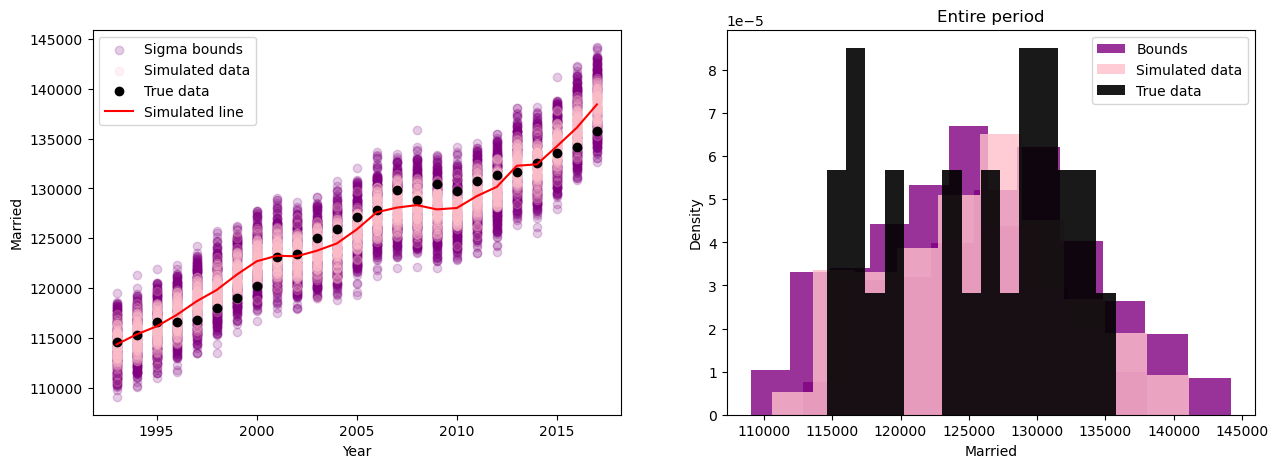

In [890]:
A = np.vstack([df['Income per member'], np.ones(len(df['Income per member']))]).T

# Parameter match - function modelling
a, b = np.linalg.lstsq(A, df['Married'], rcond=None)[0]

# Best selection of parameters
alpha = 1.26
beta = 94800
sigma = 1300

sim = random.normal(alpha*df['Income per member'] + beta, sigma, (100,25))


sim_lower = random.normal((alpha-0.04)*df['Income per member'] + (beta-1500), sigma, (100,25))
sim_upper = random.normal((alpha+0.04)*df['Income per member'] + (beta+1500), sigma, (100,25))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)

f1 = False

for i in sim_lower:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Sigma bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True

for i in sim_upper:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True    

f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='pink', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='pink', alpha=0.2)
    f1 = True



plt.scatter(df['Year'], df['Married'], color='black', label="True data")
plt.plot(df['Year'], alpha*df['Income per member'] + beta, color='red', label="Simulated line")

plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()


plt.subplot(1,2,2)
plt.hist(sim_lower.flatten().tolist(), color='purple', alpha = 0.8, density=True, label="Bounds")
plt.hist(sim_upper.flatten().tolist(), color='purple', alpha = 0.8, density=True)
plt.hist(sim.flatten().tolist(), color='pink', alpha = 0.8, density=True, label="Simulated data")

plt.hist(df['Married'], color='black',bins=15, alpha = 0.9, density=True, label="True data")
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

##### 4.2.2 Creating prior for Model I

In [891]:
# Setting data
data = {'N': N, 'income': df['Income per member']}

# creating prior for Model 1
prior_1 = model_1_prior.sample(
                    data=data,
                    iter_sampling=1000,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

02:23:01 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


02:23:01 - cmdstanpy - INFO - CmdStan done processing.


In [892]:
prior_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,1.39541,95965.8,1045.55,117728.0,117258.0,119861.0,122127.0,124763.0,...,133395.0,132548.0,132898.0,134771.0,136067.0,137231.0,137734.0,137857.0,141824.0,143624.0
1,0.0,0.0,1.31904,94585.6,1268.00,115841.0,116631.0,113332.0,119443.0,120234.0,...,130015.0,127484.0,128699.0,130290.0,132579.0,134189.0,134788.0,134351.0,137828.0,140272.0
2,0.0,0.0,1.32074,95939.3,1447.94,118117.0,119224.0,119457.0,120626.0,118589.0,...,129154.0,131673.0,133329.0,131551.0,130231.0,135769.0,135544.0,135919.0,140787.0,141657.0
3,0.0,0.0,1.27851,93917.6,1479.57,114422.0,113546.0,115347.0,113941.0,116655.0,...,126398.0,127356.0,129575.0,128747.0,129174.0,130269.0,130286.0,136031.0,135562.0,137968.0
4,0.0,0.0,1.29026,95390.9,1476.54,112250.0,116748.0,113920.0,117524.0,118534.0,...,128458.0,129939.0,130400.0,131375.0,129753.0,135243.0,134868.0,134162.0,139173.0,140199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,1.27123,98553.1,1336.82,118161.0,116637.0,119848.0,120081.0,122949.0,...,132996.0,133747.0,131594.0,131503.0,135048.0,135204.0,137249.0,137673.0,140718.0,142978.0
996,0.0,0.0,1.33231,93941.8,1339.43,114241.0,114705.0,118092.0,118153.0,119335.0,...,130013.0,128254.0,130457.0,130273.0,130556.0,132669.0,130436.0,134148.0,138366.0,139154.0
997,0.0,0.0,1.23141,95651.1,1218.71,112022.0,115512.0,117027.0,117330.0,118408.0,...,128574.0,127766.0,125896.0,127618.0,129680.0,132320.0,132092.0,133094.0,134223.0,137262.0
998,0.0,0.0,1.37256,94020.4,1497.80,115418.0,116485.0,118239.0,117606.0,118905.0,...,130367.0,132505.0,130405.0,130046.0,135794.0,134953.0,131661.0,137242.0,141492.0,141058.0


##### 4.2.3 Prior predictive checks for parameters of Model I

The simulated model parameters were checked after sampling. The obtained parameter values are consistent with the assumptions we made during their selection. So, as it was checked before, the parameters make sense. It is visible especailly, while looking on measurements.

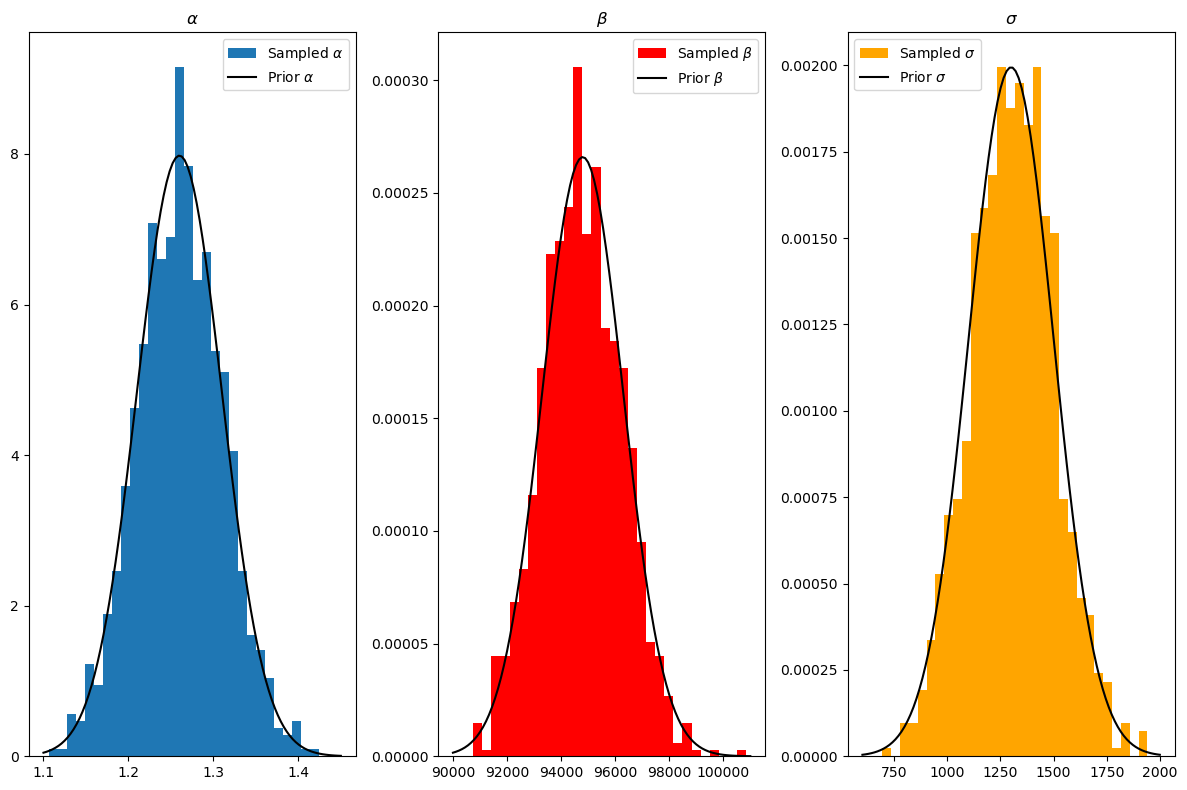

In [893]:
alpha_pred = prior_1.stan_variable('alpha')
beta_pred= prior_1.stan_variable('beta')
sigma_pred= prior_1.stan_variable('sigma')

fig,axes = plt.subplots(1,3,figsize = (12,8), tight_layout=True)
x = np.linspace(1.1,1.45,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.05)
axes[0].hist(alpha_pred, bins=30,label=r'Sampled $\alpha$',density=True)
axes[0].set_title(r'$\alpha$')
axes[0].plot(x,y,label=r'Prior $\alpha$',color='k')
axes[0].legend()

x = np.linspace(90000, 101000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=1500)
axes[1].hist(beta_pred, bins=30,label=r'Sampled $\beta$',density=True,color='r')
axes[1].set_title(r'$\beta$')
axes[1].plot(x,y,label = r'Prior $\beta$',color='k')
axes[1].legend()

x = np.linspace(600, 2000, 100)
y = stats.norm.pdf(x=x,loc=1300, scale=200)
axes[2].hist(sigma_pred, bins=30,label=r'Sampled $\sigma$',density=True,color='orange')
axes[2].set_title(r'$\sigma$')
axes[2].plot(x,y,label = r'Prior $\sigma$',color='k')
axes[2].legend()

plt.show()

##### 4.2.4 Prior predictive checks for measurements of Model I

We checked measurements for our prior predictive model and it is mostly correct. The mesurements make sense and the mean results are not bad. However, priors could have been chosen better, since the simulated results are too much dispersed.

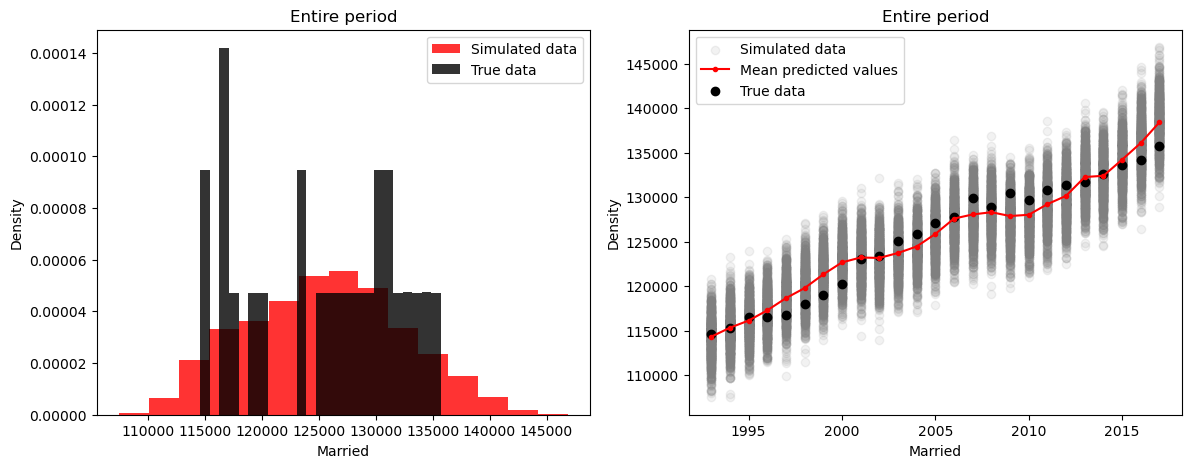

In [894]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(prior_1.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True,label='Simulated data')
plt.hist(df['Married'], bins=25, color='black', alpha = 0.8, density=True,label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.subplot(1,2,2)
flag = True
for i in prior_1.y_sim:
    if flag:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1,label='Simulated data')
        flag=False
    else:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1)


plt.plot(df['Year'], prior_1.alpha.mean()*df['Income per member'] + prior_1.beta.mean(), '.-' , color='r',label='Mean predicted values')
plt.scatter(df['Year'], df['Married'], color='k',label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

##### 4.2.5 Prior parameters selection

Priors were selected based on the prior predictive checks. Since we got good results, we decided to use simulated parameters to our model. However, the values could be modified to get better and less dispersed results.

##### 4.2.6 Prior code for model I

In [895]:
with open("prior.stan", "r") as f:
    for line in f:
        print(line)

data {

    int<lower=0> N; //number of data

    vector[N] income;

}



generated quantities {

    real alpha = normal_rng(1.26, 0.05);//intercept

    real beta = normal_rng(94800, 1500); //slope

    real<lower=0> sigma = normal_rng(1300,200);



    vector[N] y_sim; //simulated data from posterior

    

    for(i in 1:N)

	    y_sim[i] = normal_rng(alpha * income[i] + beta , sigma);

}


#### 4.3 Model II

##### 4.3.1 Parameters testing for Model II

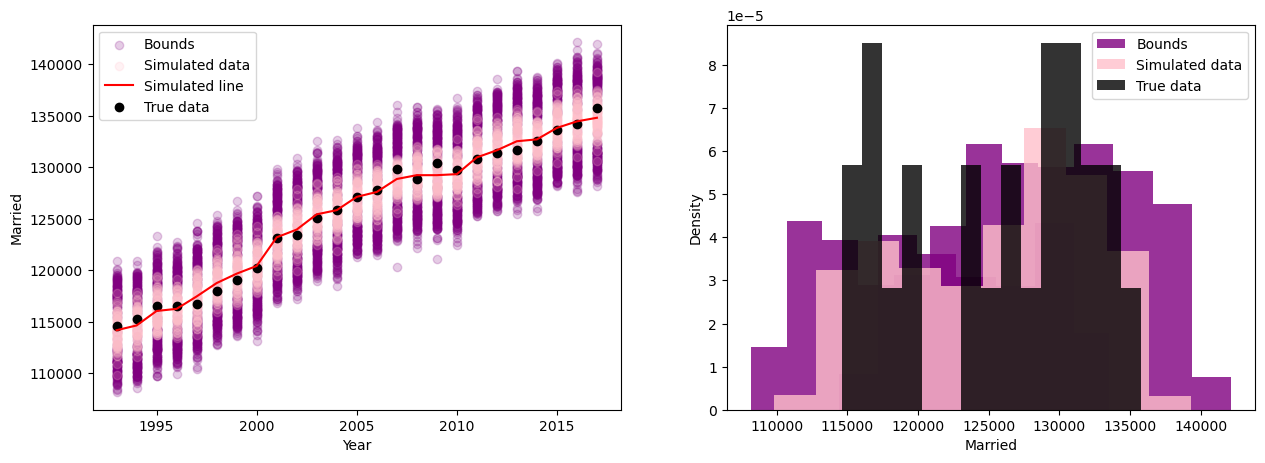

In [896]:

# Sample data
x = df['Income per member']
y = df['Household']
z = df['Mean age']

c = df['Married']

X = np.column_stack((np.ones_like(x), x, y, z))  # Add a column of ones for the intercept
coefficients = np.linalg.lstsq(X, c, rcond=None)[0]

# Extract coefficients
intercept, slope_x, slope_y, slope_z = coefficients

# Define points for the plane
z_plane = slope_x * x + slope_y * y + slope_z * z + intercept 


sim = random.normal(slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, sigma, (100,25))
sim_lower = random.normal((slope_x-0.001)*df['Income per member'] + (slope_y-0.01)*df['Household'] + (slope_z-20)*df['Mean age'] + (intercept-2000), 1200, (100,25))
sim_upper = random.normal((slope_x+0.001)*df['Income per member'] + (slope_y+0.01)*df['Household'] + (slope_z+20)*df['Mean age'] + (intercept+2000), 1200, (100,25))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
f1 = False

for i in sim_lower:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True

for i in sim_upper:
    if not f1:
        plt.scatter(df['Year'], i, color='purple', alpha=0.2, label="Bounds")
    else:    
        plt.scatter(df['Year'], i, color='purple', alpha=0.2)
    f1 = True    


f1 = False
for i in sim:
    if not f1:
        plt.scatter(df['Year'], i, label="Simulated data", color='pink', alpha=0.2)
    else:    
        plt.scatter(df['Year'], i, color='pink', alpha=0.2)
    f1 = True


plt.plot(df['Year'], slope_x*df['Income per member'] + slope_y*df['Household'] + slope_z*df['Mean age'] + intercept, color="red", label='Simulated line')
plt.scatter(df['Year'], df['Married'], color="k", label='True data')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()

plt.subplot(1,2,2)

plt.hist(sim_lower.flatten().tolist(), color='purple', alpha = 0.8, density=True)
plt.hist(sim_upper.flatten().tolist(), color='purple', alpha = 0.8, density=True, label="Bounds")
plt.hist(sim.flatten().tolist(), color='pink', alpha = 0.8, density=True, label="Simulated data")
plt.hist(df['Married'], color='black',bins=15, alpha = 0.8, density=True, label='True data')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()
plt.show()

##### 4.3.2 Creating prior for Model II

In [897]:
# Setting data
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age']}

# creating prior for Model 1
prior_2 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

02:23:14 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


02:23:14 - cmdstanpy - INFO - CmdStan done processing.


In [898]:
prior_2.draws_pd()

,lp__,accept_stat__,alpha_1,alpha_2,alpha_3,beta,sigma,y_sim[1],y_sim[2],y_sim[3],...,y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23],y_sim[24],y_sim[25]
0,0.0,0.0,0.014708,0.817772,1254.55,68755.2,422.116,115922.0,116796.0,118670.0,...,131138.0,131366.0,131578.0,132755.0,133602.0,133739.0,134693.0,135509.0,136935.0,136735.0
1,0.0,0.0,0.011840,0.816388,1288.60,62824.4,907.013,109317.0,110130.0,110335.0,...,124702.0,124267.0,124692.0,124660.0,126437.0,127324.0,128608.0,129321.0,129940.0,130690.0
2,0.0,0.0,0.013213,0.817903,1295.36,65232.6,1154.010,112894.0,110815.0,113706.0,...,126584.0,125364.0,127775.0,128163.0,129314.0,129095.0,130988.0,131618.0,130776.0,131899.0
3,0.0,0.0,0.010109,0.800013,1304.34,66800.5,641.695,111248.0,112976.0,112628.0,...,125486.0,125492.0,126075.0,127534.0,128520.0,127445.0,129111.0,128624.0,130290.0,130460.0
4,0.0,0.0,0.012259,0.794668,1259.70,70734.9,601.492,115191.0,115196.0,117080.0,...,130084.0,130381.0,130969.0,132007.0,132074.0,134075.0,133199.0,134627.0,135387.0,136679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.010789,0.799298,1277.12,66982.7,823.804,112052.0,112428.0,115240.0,...,127711.0,126165.0,125587.0,129014.0,129241.0,129625.0,128427.0,130658.0,132643.0,131495.0
96,0.0,0.0,0.012588,0.813148,1287.05,69854.7,995.281,115506.0,117214.0,118055.0,...,130891.0,132412.0,130651.0,132290.0,133675.0,133846.0,133331.0,135080.0,136904.0,136440.0
97,0.0,0.0,0.013253,0.812071,1244.70,68002.4,231.817,114633.0,115396.0,116361.0,...,129555.0,130125.0,130298.0,131602.0,132045.0,133321.0,133590.0,134654.0,135044.0,136205.0
98,0.0,0.0,0.011151,0.806342,1310.00,63997.8,819.958,108261.0,107982.0,110762.0,...,123033.0,123208.0,124025.0,126392.0,127532.0,126735.0,127104.0,129298.0,129222.0,129285.0


##### 4.3.3 Prior predictive checks for parameters of Model II

The simulated model parameters were checked after sampling. The obtained parameter values are consistent with the assumptions we made during their selection. However, we can notice that the results are a bit moved to one side.


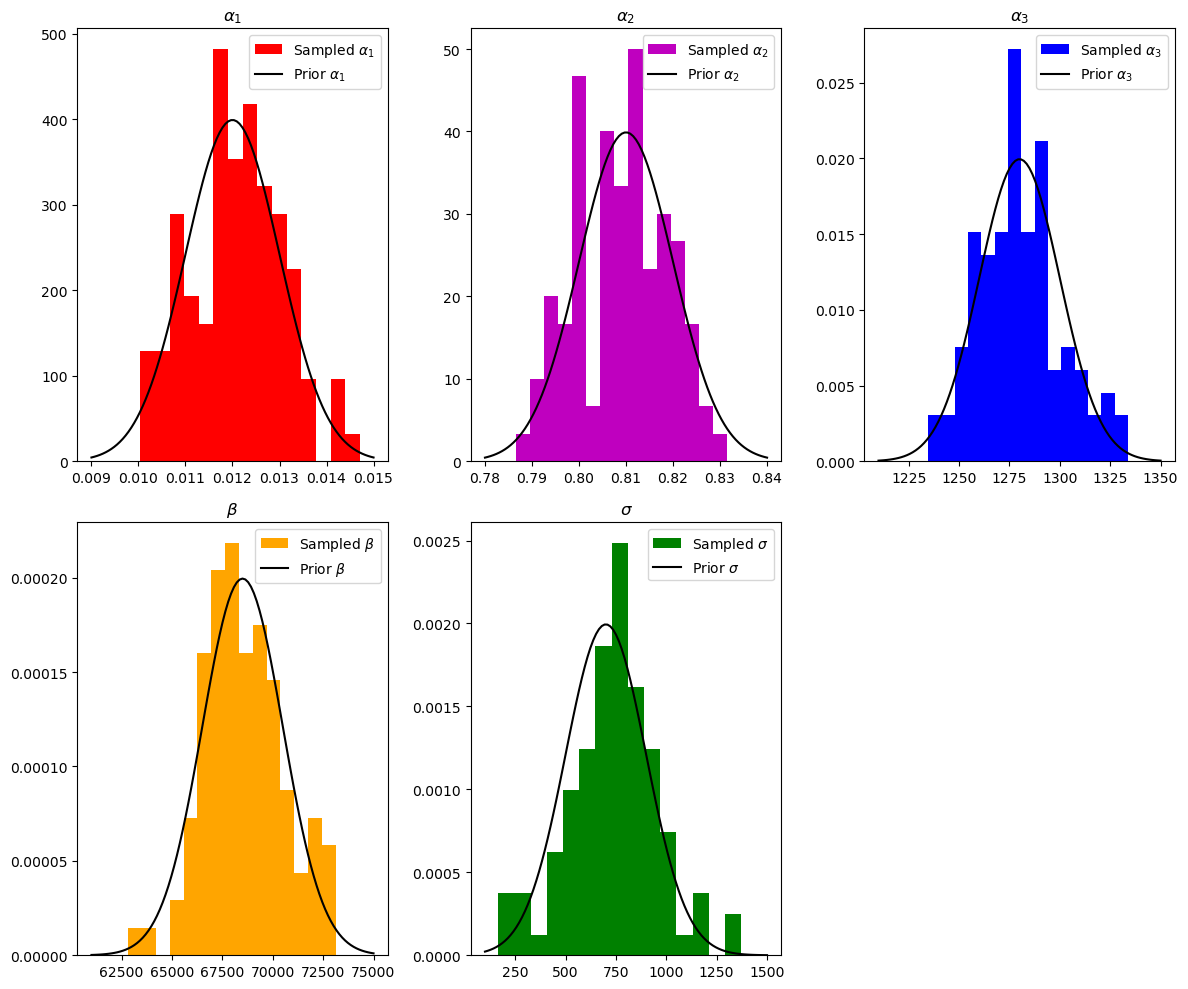

In [899]:
alpha1_pred = prior_2.stan_variable('alpha_1')
alpha2_pred = prior_2.stan_variable('alpha_2')
alpha3_pred = prior_2.stan_variable('alpha_3')
beta_pred= prior_2.stan_variable('beta')
sigma_pred= prior_2.stan_variable('sigma')

fig,axes = plt.subplots(2,3,figsize = (12,10), tight_layout=True)
x = np.linspace(0.009,0.015,100)
y = stats.norm.pdf(x=x,loc=0.012, scale=0.001)
axes[0][0].hist(alpha1_pred, bins=15,label=r'Sampled $\alpha_1$',density=True,color='r')
axes[0][0].set_title(r'$\alpha_1$')
axes[0][0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0][0].legend()

x = np.linspace(0.78,0.84,100)
y = stats.norm.pdf(x=x,loc=0.81, scale=0.01)
axes[0][1].hist(alpha2_pred, bins=15,label=r'Sampled $\alpha_2$',density=True,color='m')
axes[0][1].set_title(r'$\alpha_2$')
axes[0][1].plot(x,y,label=r'Prior $\alpha_2$',color='k')
axes[0][1].legend()

x = np.linspace(1210,1350,100)
y = stats.norm.pdf(x=x,loc=1280, scale=20)
axes[0][2].hist(alpha3_pred, bins=15,label=r'Sampled $\alpha_3$',density=True,color='b')
axes[0][2].set_title(r'$\alpha_3$')
axes[0][2].plot(x,y,label=r'Prior $\alpha_3$',color='k')
axes[0][2].legend()

x = np.linspace(61000, 75000, 100)
y = stats.norm.pdf(x=x,loc=68500, scale=2000)
axes[1][0].hist(beta_pred, bins=15,label=r'Sampled $\beta$',density=True,color='orange')
axes[1][0].set_title(r'$\beta$')
axes[1][0].plot(x,y,label = r'Prior $\beta$',color='k')
axes[1][0].legend()

x = np.linspace(100, 1500, 100)
y = stats.norm.pdf(x=x,loc=700, scale=200)
axes[1][1].hist(sigma_pred, bins=15,label=r'Sampled $\sigma$',density=True,color='g')
axes[1][1].set_title(r'$\sigma$')
axes[1][1].plot(x,y,label = r'Prior $\sigma$',color='k')
axes[1][1].legend()

fig.delaxes(axes[1, 2])

plt.show()

##### 4.3.4 Prior predictive checks for measurements of Model II

We checked measurements for our prior predictive model and it is mostly correct. The mesurements make sense and the mean results are very good. However, the issue with too dispersed simulated results also appeared here. We should adjust sigma values in normal distributions to fix this problem.

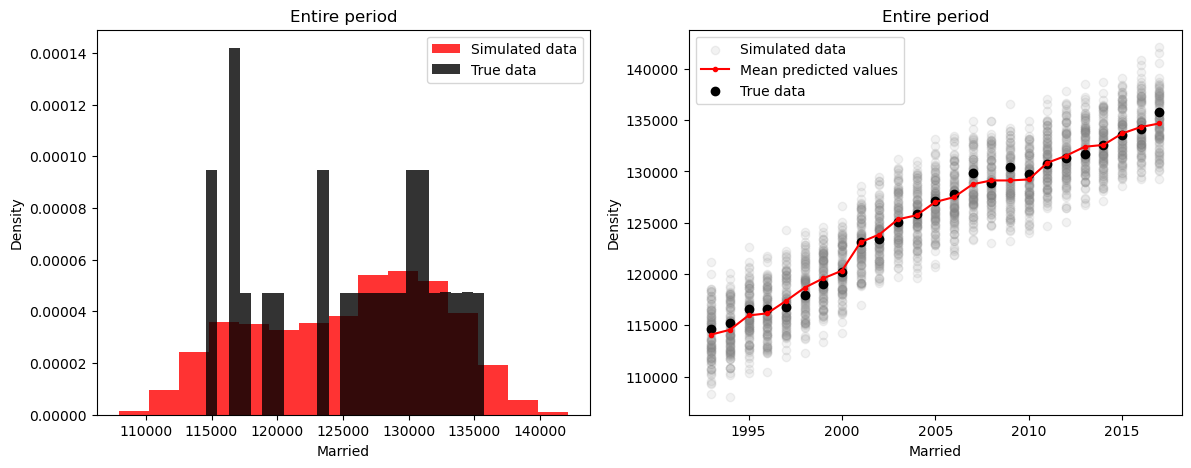

In [900]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(prior_2.y_sim.flatten().tolist(), bins=15, color='red', alpha = 0.8, density=True,label='Simulated data')
plt.hist(df['Married'], bins=25, color='black', alpha = 0.8, density=True,label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.subplot(1,2,2)
flag = True
for i in prior_2.y_sim:
    if flag:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1,label='Simulated data')
        flag=False
    else:
        plt.scatter(df['Year'], i, color='gray', alpha = 0.1)


plt.plot(df['Year'], prior_2.alpha_1.mean()*df['Income per member'] + prior_2.alpha_2.mean()*df['Household'] - prior_2.alpha_3.mean()*df['Mean age'] + prior_2.beta.mean(), '.-' , color='r',label='Mean predicted values')
plt.scatter(df['Year'], df['Married'], color='k',label='True data')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()

plt.show()

##### 4.2.5 Prior parameters selection

Priors were selected based on the prior predictive checks. Mean values give us pretty good results, however we should adjust the dispersion in te future.

##### 4.2.6 Prior code for model II

In [901]:
with open("tri_prior.stan", "r") as f:
    for line in f:
        print(line)

data {

    int<lower=0> N; //number of data

    vector[N] income;

    vector[N] household;

    vector[N] mean_age;

}



generated quantities {

    real alpha_1 = normal_rng(0.012, 0.001);  //slope 1

    real alpha_2 = normal_rng(0.81, 0.01);  //slope 2

    real alpha_3 = normal_rng(1280, 20);  //slope 3

    real beta = normal_rng(68500, 2000);  //intercept

    real<lower=0> sigma = normal_rng(700,200); //scatter



    vector[N] y_sim; //simulated data from posterior

    

    for(i in 1:N)

	    y_sim[i] = normal_rng(alpha_1 * income[i] + alpha_2 * household[i] - alpha_3 * mean_age[i] + beta , sigma);

}


### 5. Model I - posterior analysis

##### 5.1 Sampling
There were no issues with sampling. We are using normal distribution in all situations where sampling is needed, so there are not any problems with bounds for parameters. Also, we are working with (mostly) total numbers that are locatd far from zero, so there are no such issues. We only had issues with deprecated functions in stan.

##### 5.2  Creating posterior model

In [902]:
data = {'N': N, 'income': df['Income per member'], 'y': df['Married']}
post_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=100)

02:23:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


02:23:17 - cmdstanpy - INFO - CmdStan done processing.


##### 5.3  Analysis of samples from posterior predictive distribution

On the plots we can see prior samples, posterior samples and the line that was selected for prior. We can see that parametrs alpha, sigma and beta in posterior samples are narrowed to the specific range of parameters, that are included in prior samples. It is not exactly bad behaviour, despite posterior samples are not the same as prior. Sigma samples especially should be adjusted to get better results - the ceter is moved to the right side of prior samples and additionaly, it is narrowed. 

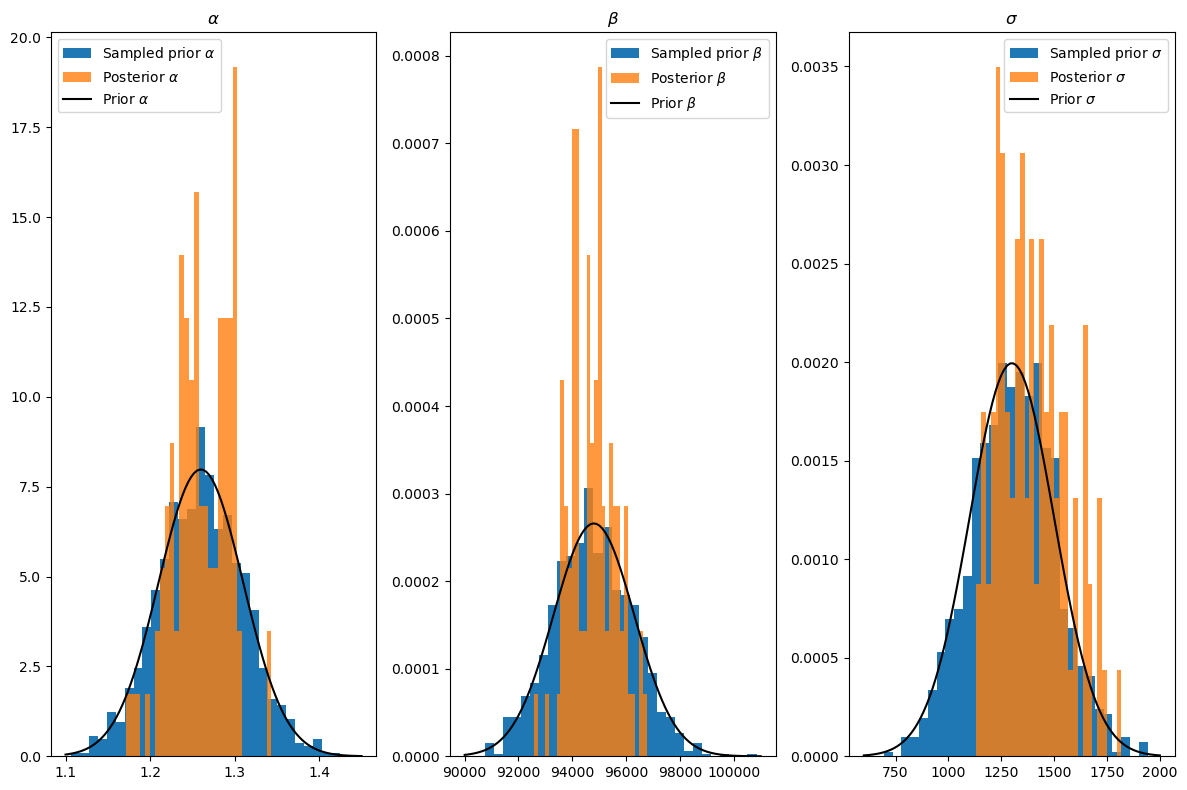

In [903]:
alpha_pred_post = post_1.stan_variable('alpha')
beta_pred_post = post_1.stan_variable('beta')
sigma_pred_post = post_1.stan_variable('sigma')


fig,axes = plt.subplots(1,3,figsize = (12,8), tight_layout=True)
x = np.linspace(1.1,1.45,100)
y = stats.norm.pdf(x=x,loc=1.26, scale=0.05)
axes[0].hist(prior_1.stan_variable('alpha'), bins=30,label=r'Sampled prior $\alpha$',density=True)
axes[0].set_title(r'$\alpha$')
axes[0].hist(alpha_pred_post, bins=30,label=r'Posterior $\alpha$',density=True, alpha=0.8)
axes[0].plot(x,y,label=r'Prior $\alpha$',color='k')
axes[0].legend()

x = np.linspace(90000, 101000, 100)
y = stats.norm.pdf(x=x,loc=94800, scale=1500)
axes[1].hist(prior_1.stan_variable('beta'), bins=30,label=r'Sampled prior $\beta$',density=True)
axes[1].set_title(r'$\beta$')
axes[1].hist(beta_pred_post, bins=30,label=r'Posterior $\beta$',density=True, alpha=0.8)
axes[1].plot(x,y,label=r'Prior $\beta$',color='k')
axes[1].legend()

x = np.linspace(600, 2000, 100)
y = stats.norm.pdf(x=x,loc=1300, scale=200)
axes[2].hist(prior_1.stan_variable('sigma'), bins=30,label=r'Sampled prior $\sigma$',density=True)
axes[2].set_title(r'$\sigma$')
axes[2].hist(sigma_pred_post, bins=30,label=r'Posterior $\sigma$',density=True, alpha=0.8)
axes[2].plot(x,y,label=r'Prior $\sigma$',color='k')
axes[2].legend()

plt.show()

##### 5.4  Is data consistent with posterior predictive samples?

Posterior predictive samples give us medium results - if we look on the plots below we can see that the trend remains, but the data is not fully consistent with the priors. The reason for that is probably the fact that our predictors are limited and it may be difficult to adjust function to our data. Also, the distributions of the parameters are not perfect - if we try to find better parameters distributions, maybe we could get better results.

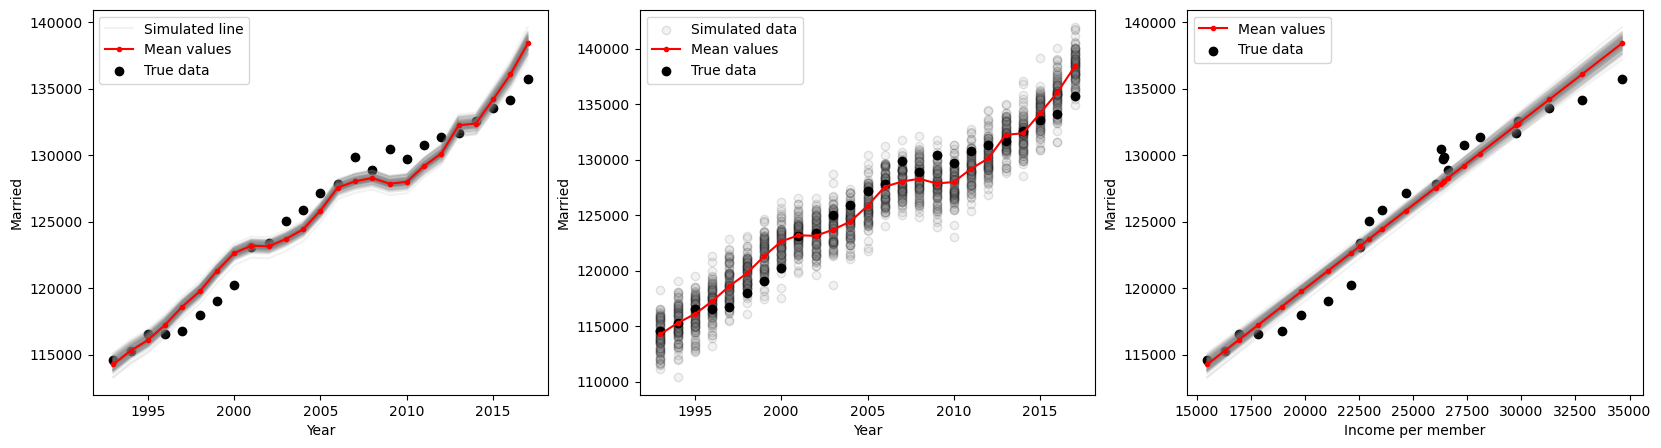

In [904]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
f = True
for i in range(len(post_1.y_sim)):
    if f:
        plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='gray', alpha = 0.1, label='Simulated line')
        f=False
    else:
        plt.plot(df['Year'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='gray', alpha = 0.1)
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), '.-', color='red', label='Mean values')   
plt.scatter(df['Year'], df['Married'], color='black', label='True data')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()

plt.subplot(1,3,2)
f = True
for i in range(len(post_1.y_sim)):
    if f:
        plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black", label='Simulated data')
        f=False
    else:    
        plt.scatter(df['Year'], post_1.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(),'.-', color='red', label='Mean values')   
plt.scatter(df['Year'], df['Married'], color='black', label='True data')
plt.xlabel('Year')
plt.ylabel('Married')
plt.legend()

plt.subplot(1,3,3)
for i in range(len(post_1.y_sim)):
    plt.plot(df['Income per member'], post_1.alpha[i]*df['Income per member'] + post_1.beta[i], color='gray', alpha = 0.1)
plt.plot(df['Income per member'], post_1.alpha.mean()*df['Income per member'] + post_1.beta.mean(), '.-', color='red', label='Mean values')   
plt.scatter(df['Income per member'], df['Married'], color='black', label='True data')
plt.xlabel('Income per member')
plt.ylabel('Married')
plt.legend()


plt.show()

In [905]:
post_1.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-189.21000,0.212583,1.173630,-191.47500,-189.14900,-187.70700,30.4791,3386.57,1.128030
alpha,1.26043,0.005736,0.033366,1.20678,1.25993,1.30213,33.8359,3759.54,1.004480
beta,94738.80000,144.422000,822.263000,93570.90000,94719.70000,96016.90000,32.4158,3601.75,1.001940
sigma,1400.83000,18.613000,160.628000,1174.71000,1384.62000,1677.97000,74.4753,8275.03,0.990401
y_sim[1],114192.00000,144.949000,1387.540000,111710.00000,114187.00000,116182.00000,91.6348,10181.60,0.998382
y_sim[2],115271.00000,177.507000,1530.480000,112834.00000,115176.00000,117619.00000,74.3402,8260.02,1.014070
y_sim[3],116014.00000,166.950000,1483.210000,113185.00000,116109.00000,118059.00000,78.9281,8769.79,1.003240
y_sim[4],117225.00000,142.619000,1435.850000,114434.00000,117385.00000,119289.00000,101.3590,11262.10,0.990636
y_sim[5],118746.00000,153.370000,1525.220000,116339.00000,118611.00000,121278.00000,98.8966,10988.50,1.009820
y_sim[6],119792.00000,119.395000,1245.030000,117858.00000,119876.00000,121660.00000,108.7400,12082.30,0.998594


##### 5.5  Marginal distributions

Parameters are concentrated in the specific range that is narrower that the range stated in prior. However, the values we received, are correct values and they have sense. Even the marginal values are placed in expected range.

##### 5.6 Posterior code for model I

In [906]:
with open("posterior.stan", "r") as f:
    for line in f:
        print(line)

data {

    int<lower=0> N; //number of data

    array[N] real income;

    array[N] real y;

}



parameters {

    real alpha;//intercept

    real beta; //slope

    real<lower=0> sigma;

}



model {

    //priors

    alpha ~ normal(1.26, 0.05);

    beta ~ normal(94800, 1500);

    sigma ~ normal(1300,200);

    

    for(n in 1:N)

        y[n] ~ normal(alpha * income[n]  + beta , sigma); //likelihood

}



generated quantities {

    array[N] real y_sim; //simulated data from posterior

    array[N] real log_lik;



    for(i in 1:N){

        y_sim[i] = normal_rng(alpha * income[i] + beta , sigma);

        log_lik[i] = normal_lpdf(y[i] | alpha * income[i] + beta , sigma);

    }

	    

}


### 6. Model II - posterior analysis

##### 6.1 Sampling
There were no issues with sampling. We are using normal distribution in all situations where sampling is needed, so there are not any problems with bounds for parameters. Also, we are working with (mostly) total numbers that are locatd far from zero, so there are no such issues. We only had issues with deprecated functions in stan.

##### 6.2  Creating posterior model

In [907]:
data = {'N': N, 'income': df['Income per member'], 'household': df['Household'], 'mean_age': df['Mean age'], 'y': df['Married']}
post_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=100)

02:23:19 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                     


02:23:20 - cmdstanpy - INFO - CmdStan done processing.


##### 6.3  Analysis of samples from posterior predictive distribution

As in previous model, the received posterior samples are all within the range of previous prior samples. We can assume that the values have sense and can be used as reliable. However, we can see that values of all alpha parameters were selected pretty well. Beta and sigma could have been selected better.

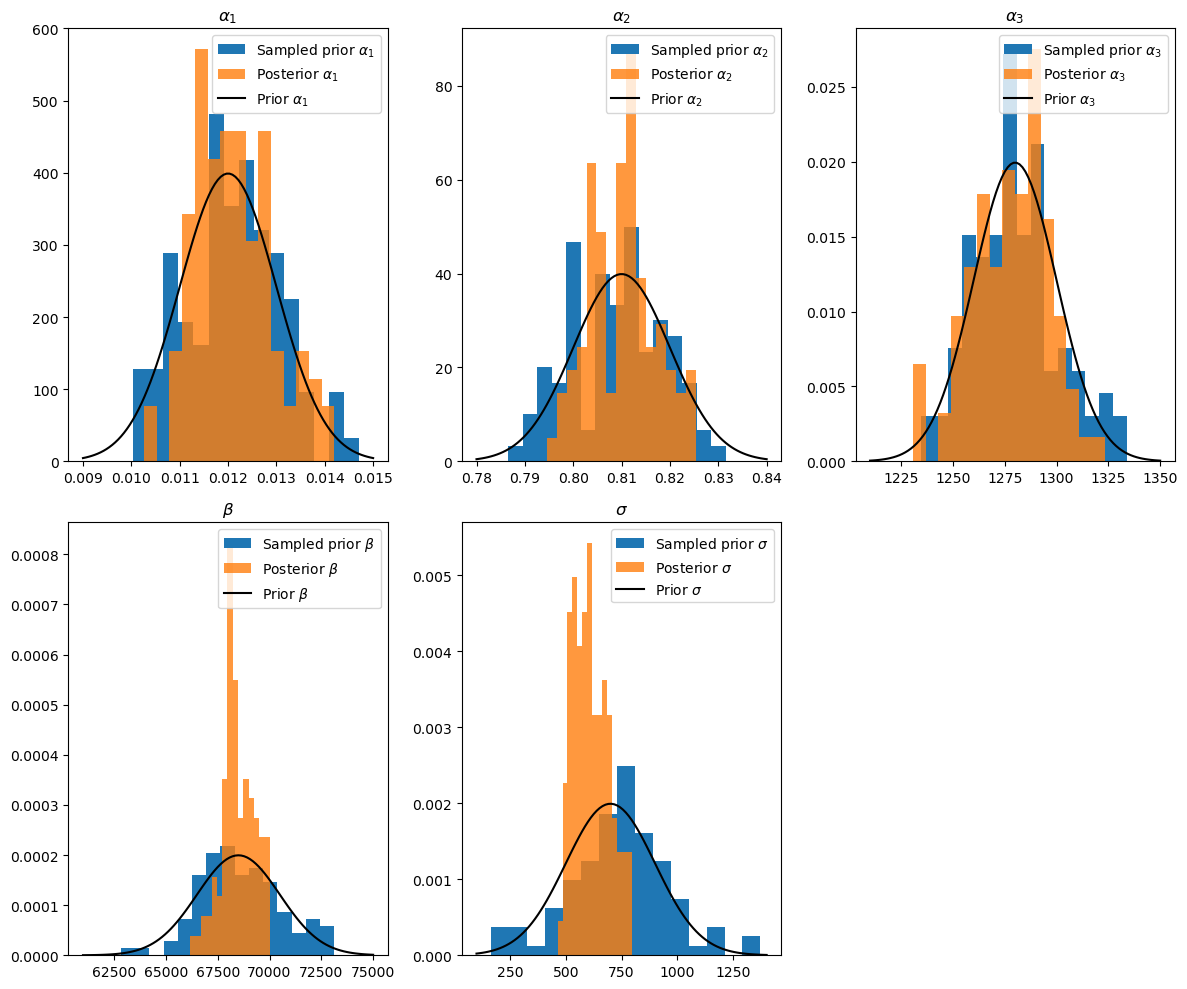

In [908]:
alpha1_pred_post = post_2.stan_variable('alpha_1')
alpha2_pred_post = post_2.stan_variable('alpha_2')
alpha3_pred_post = post_2.stan_variable('alpha_3')
beta_pred_post = post_2.stan_variable('beta')
sigma_pred_post = post_2.stan_variable('sigma')

fig,axes = plt.subplots(2,3,figsize = (12,10), tight_layout=True)
x = np.linspace(0.009,0.015,100)
y = stats.norm.pdf(x=x,loc=0.012, scale=0.001)
axes[0][0].hist(alpha1_pred, bins=15,label=r'Sampled prior $\alpha_1$',density=True)
axes[0][0].set_title(r'$\alpha_1$')
axes[0][0].hist(alpha1_pred_post, bins=15,label=r'Posterior $\alpha_1$',density=True, alpha=0.8)
axes[0][0].plot(x,y,label=r'Prior $\alpha_1$',color='k')
axes[0][0].legend()

x = np.linspace(0.78,0.84,100)
y = stats.norm.pdf(x=x,loc=0.81, scale=0.01)
axes[0][1].hist(alpha2_pred, bins=15,label=r'Sampled prior $\alpha_2$',density=True)
axes[0][1].set_title(r'$\alpha_2$')
axes[0][1].hist(alpha2_pred_post, bins=15,label=r'Posterior $\alpha_2$',density=True, alpha=0.8)
axes[0][1].plot(x,y,label=r'Prior $\alpha_2$',color='k')
axes[0][1].legend()

x = np.linspace(1210,1350,100)
y = stats.norm.pdf(x=x,loc=1280, scale=20)
axes[0][2].hist(alpha3_pred, bins=15,label=r'Sampled prior $\alpha_3$',density=True)
axes[0][2].set_title(r'$\alpha_3$')
axes[0][2].hist(alpha3_pred_post, bins=15,label=r'Posterior $\alpha_3$',density=True, alpha=0.8)
axes[0][2].plot(x,y,label=r'Prior $\alpha_3$',color='k')
axes[0][2].legend()

x = np.linspace(61000, 75000, 100)
y = stats.norm.pdf(x=x,loc=68500, scale=2000)
axes[1][0].hist(beta_pred, bins=15,label=r'Sampled prior $\beta$',density=True)
axes[1][0].set_title(r'$\beta$')
axes[1][0].hist(beta_pred_post, bins=15,label=r'Posterior $\beta$',density=True, alpha=0.8)
axes[1][0].plot(x,y,label=r'Prior $\beta$',color='k')
axes[1][0].legend()

x = np.linspace(100, 1400, 100)
y = stats.norm.pdf(x=x,loc=700, scale=200)
axes[1][1].hist(sigma_pred, bins=15,label=r'Sampled prior $\sigma$',density=True)
axes[1][1].set_title(r'$\sigma$')
axes[1][1].hist(sigma_pred_post, bins=15,label=r'Posterior $\sigma$',density=True, alpha=0.8)
axes[1][1].plot(x,y,label=r'Prior $\sigma$',color='k')
axes[1][1].legend()

fig.delaxes(axes[1, 2])

plt.show()

##### 6.4  Is data consistent with posterior predictive samples?

We can see on the plots below that posterior predictive samples are not fully consistent with the data, but they are more consistent than our previous model. We can assume that this is mostly thanks to increasing the number of predictors in a model and changing function to a more complex one.

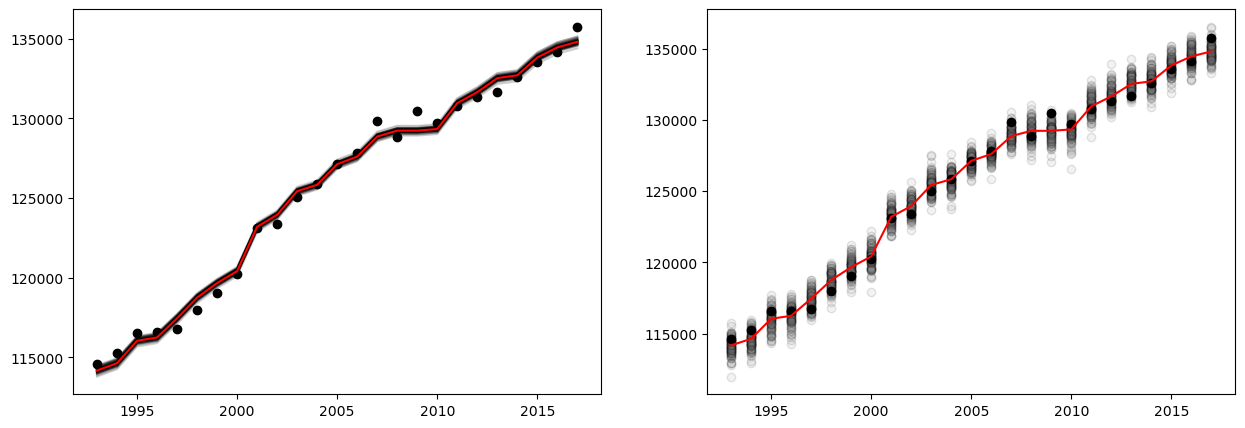

In [909]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
for i in range(len(post_2.y_sim)):
    plt.plot(df['Year'], post_2.alpha_1[i]*df['Income per member'] + post_2.alpha_2[i]*df['Household'] - post_2.alpha_3[i]*df['Mean age'] + post_2.beta[i], color='black', alpha = 0.1)
plt.plot(df['Year'], post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_2.y_sim)):
    plt.scatter(df['Year'], post_2.y_sim[i], color='gray', alpha = 0.1,edgecolors= "black")
plt.plot(df['Year'], post_2.alpha_1.mean()*df['Income per member'] + post_2.alpha_2.mean()*df['Household'] - post_2.alpha_3.mean()*df['Mean age'] + post_2.beta.mean(), color='red')   
plt.scatter(df['Year'], df['Married'], color='black')

plt.show()

In [910]:
post_2.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-166.430000,0.170380,1.286960,-169.067000,-166.188000,-164.998000,57.0549,1097.21,1.001350
alpha_1,0.012122,0.000099,0.000814,0.010977,0.012084,0.013629,67.0878,1290.15,1.057490
alpha_2,0.810294,0.000556,0.006839,0.798742,0.810781,0.822235,151.5710,2914.82,1.038240
alpha_3,1277.680000,2.344190,18.452400,1245.310000,1279.650000,1303.790000,61.9614,1191.56,0.999227
beta,68457.400000,79.352500,791.788000,66958.200000,68383.400000,69762.200000,99.5628,1914.67,1.006950
sigma,612.457000,9.961580,78.514200,500.819000,606.684000,756.226000,62.1212,1194.64,0.990849
y_sim[1],114113.000000,53.772900,593.085000,112938.000000,114107.000000,115017.000000,121.6490,2339.40,0.996204
y_sim[2],114550.000000,55.183200,596.848000,113629.000000,114490.000000,115570.000000,116.9810,2249.63,0.992070
y_sim[3],116007.000000,62.707800,699.932000,114776.000000,116095.000000,117054.000000,124.5860,2395.88,0.992229
y_sim[4],116317.000000,84.507800,671.756000,114936.000000,116449.000000,117304.000000,63.1873,1215.14,0.990336


##### 6.5  Marginal distributions

Parameters are concentrated in the specific range that is often narrower that the range stated in prior. However, the values we received, are correct values and they have sense. Most of the marginal values are placed in expected range. In the second model we can also see that some of the parameters posterior samples are very familiar to prior samples.

##### 6.6 Posterior code for model II

In [911]:
with open("tri_posterior.stan", "r") as f:
    for line in f:
        print(line)

data {

    int<lower=0> N; //number of data

    array[N] real income; 

    array[N] real household;

    array[N] real mean_age;

    array[N] real y;

}



parameters {

    real alpha_1;//slope 1

    real alpha_2;//slope 2

    real alpha_3;//slope 3

    real beta; //intercept

    real<lower=0> sigma; //scatter

}



model {

    //priors

    alpha_1 ~ normal(0.012, 0.001);

    alpha_2 ~ normal(0.81, 0.01);

    alpha_3 ~ normal(1280, 20);

    beta ~ normal(68500, 2000);

    sigma ~ normal(700,200);

    

    for(n in 1:N)

        y[n] ~ normal(alpha_1 * income[n] + alpha_2 * household[n] - alpha_3 * mean_age[n] + beta , sigma); //likelihood

}



generated quantities {

    array[N] real y_sim; //simulated data from posterior

    array[N] real log_lik;



    for(i in 1:N){

        y_sim[i] = normal_rng(alpha_1 * income[i] + alpha_2 * household[i] - alpha_3 * mean_age[i] + beta , sigma);

        log_lik[i] = normal_lpdf(y[i] | alpha_1 * income[i] + alpha_2 * household

### 7. Model comparison

##### 7.1 Information criteria
The WAIC and LOO (information criteria) were used for model comparison, and both indicated that the more complex model achieves better results, which is also consistent with the level of fit of the plotted graph over the entire data range. If we consider only the subset of data that was not included in the model fitting process, the more complex model also performs better.

##### 7.2 WAIC

c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\p

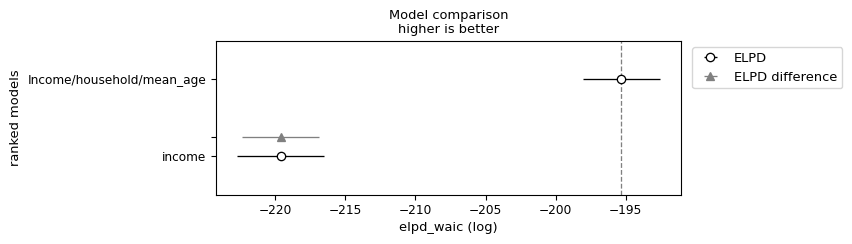

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-195.317540,1.416273,0.000000,1.000000e+00,2.750490,0.000000,False,log
income,1,-219.626201,1.915179,24.308662,6.856737e-13,3.093638,2.750696,True,log


In [912]:
# Compare the models using WAIC
waic_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="waic")

az.plot_compare(waic_compare)
plt.show()
waic_compare

In [913]:
az.waic(post_1)

c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -219.63     3.09
p_waic        1.92        -

There has been a warning during the calculation. Please check the results.

In [914]:
az.waic(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -195.32     2.75
p_waic        1.42        -

##### 7.3 PSIS-LOO

c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\Julia\anaconda3\envs\studia\Lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0

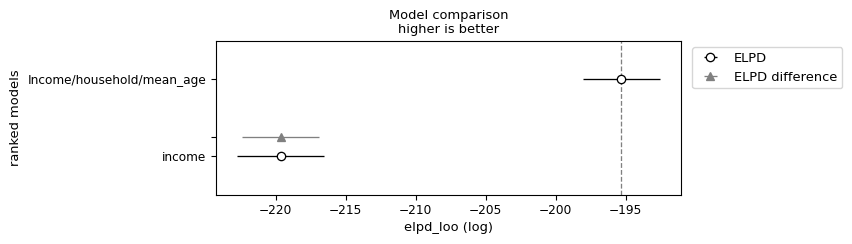

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Income/household/mean_age,0,-195.31688,1.415613,0.0000,1.0,2.745671,0.000000,False,log
income,1,-219.65308,1.942058,24.3362,0.0,3.097320,2.757322,False,log


In [915]:
# Compare the models using LOO
loo_compare = az.compare({"income": post_1, "Income/household/mean_age": post_2}, ic="loo")

az.plot_compare(loo_compare)
plt.show()
loo_compare

In [916]:
az.loo(post_1)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -219.65     3.10
p_loo        1.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       25  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [917]:
az.loo(post_2)

Computed from 100 posterior samples and 25 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -195.32     2.75
p_loo        1.42        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       24   96.0%
 (0.5, 0.7]   (ok)          1    4.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

##### 7.4 Model comparison discussion

Porównaliśmy oba nasze modele z wykorzystaniem information criteria - WAIC and LOO. 
Zarówno kryterium WAIC jak i LOO wskazało, że model z kilkoma predyktorami daje lepsze wyniki niż model z jednym predyktorem.

TO DO
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

##### 7.5 Checking model for unknown data
For both criteria, the more complex model achieved a higher score, so it can be considered better than the simpler one.

In [918]:
data = {'N': 5, 'income': df_all['Income per member'][25:], 'y': df_all['Married'][25:]}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 5, 'income': df_all['Income per member'][25:], 'household': df_all['Household'][25:], 'mean_age': df_all['Mean age'][25:], 'y': df_all['Married'][25:]}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

02:23:24 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


02:23:24 - cmdstanpy - INFO - CmdStan done processing.
02:23:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed                     


02:23:25 - cmdstanpy - INFO - CmdStan done processing.


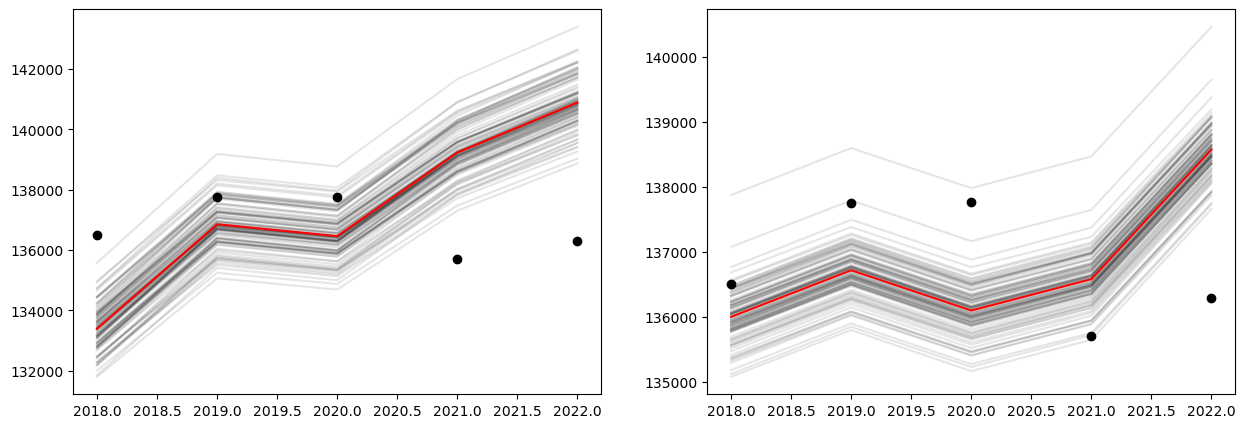

In [919]:
plt.figure(figsize=(15,5))

df_whole = df_all
df_all = df_all[25:]
plt.subplot(1,2,1)
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.subplot(1,2,2)
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

TO DO


##### 7.6 Checking models for all data

In [920]:
data = {'N': 30, 'income': df_whole['Income per member'], 'y': df_whole['Married']}
post_test_1 = model_1_posterior.sample(data=data, chains=1, iter_sampling=R)

data = {'N': 30, 'income': df_whole['Income per member'], 'household': df_whole['Household'], 'mean_age': df_whole['Mean age'], 'y': df_whole['Married']}
post_test_2 = model_2_posterior.sample(data=data, chains=1, iter_sampling=R)

02:23:26 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


02:23:26 - cmdstanpy - INFO - CmdStan done processing.
02:23:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |██████████| 00:01 Sampling completed                     


02:23:27 - cmdstanpy - INFO - CmdStan done processing.


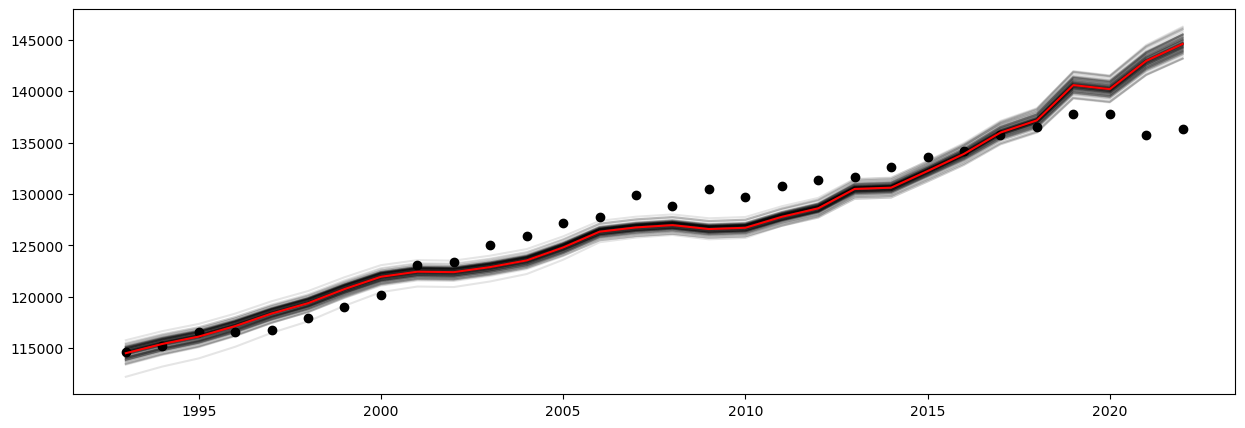

In [921]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_1.y_sim)):
    plt.plot(df_all['Year'], post_test_1.alpha[i]*df_all['Income per member'] + post_test_1.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_1.alpha.mean()*df_all['Income per member'] + post_test_1.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

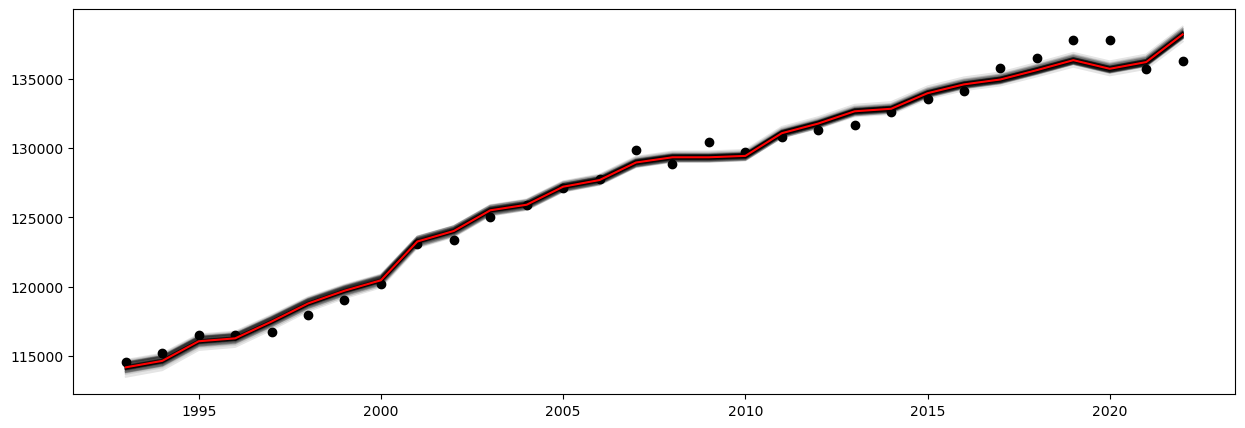

In [922]:
plt.figure(figsize=(15,5))

df_all = df_whole
for i in range(len(post_test_2.y_sim)):
    plt.plot(df_all['Year'], post_test_2.alpha_1[i]*df_all['Income per member'] + post_test_2.alpha_2[i]*df_all['Household'] - post_test_2.alpha_3[i]*df_all['Mean age'] + post_test_2.beta[i], color='black', alpha = 0.1)
plt.plot(df_all['Year'], post_test_2.alpha_1.mean()*df_all['Income per member'] + post_test_2.alpha_2.mean()*df_all['Household'] - post_test_2.alpha_3.mean()*df_all['Mean age'] + post_test_2.beta.mean(), color='red')   
plt.scatter(df_all['Year'], df_all['Married'], color='black')

plt.show()

TO DO